<a href="https://www.dominodatalab.com/blog/fitting-support-vector-machines-quadratic-programming">Article Link</a>

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from cvxopt import matrix, solvers
from sklearn.datasets import load_iris

C = 100

In [2]:
iris = load_iris()
iris_df = pd.DataFrame(data= np.c_[iris["data"], iris["target"]], columns= iris["feature_names"] + ["target"])
# Retain only 2 linearly separable classes
iris_df = iris_df[iris_df["target"].isin([0,1])]
iris_df["target"] = iris_df[["target"]].replace(0,-1)
# Select only 2 attributes
iris_df = iris_df[["petal length (cm)", "petal width (cm)", "target"]]
iris_df.head()

,petal length (cm),petal width (cm),target
0,1.4,0.2,-1.0
1,1.4,0.2,-1.0
2,1.3,0.2,-1.0
3,1.5,0.2,-1.0
4,1.4,0.2,-1.0


In [3]:
df = pd.read_csv('non-separable-data.csv')
df.head()
df.color = df.color.replace(0,-1)
X = df[['x', 'y']].to_numpy()  #iris_df[["petal length (cm)", "petal width (cm)"]].to_numpy()
y = df['color'].to_numpy().reshape((-1,1))   #iris_df[["target"]].to_numpy()
x_min = X[:, 0].min()-0.1
x_max = X[:, 0].max()+0.1
y_min = X[:, 1].min()-0.1
y_max = X[:, 1].max()+0.1

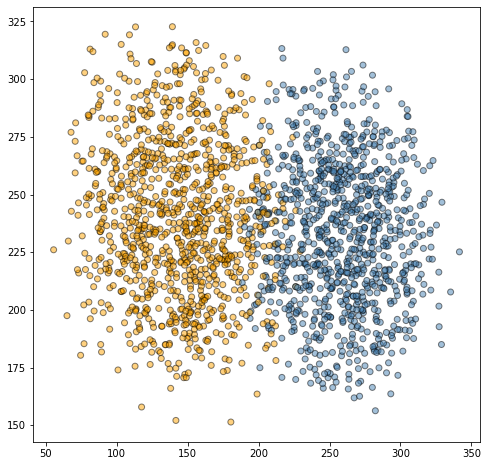

In [4]:
plt.figure(figsize=(8, 8))
colors = ["steelblue", "orange"]
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
plt.show()

<h3 style="text-align: center;">General Form of CVXOPT</h3><br>
\begin{equation}
\begin{aligned}
\min \quad & (1/2) \boldsymbol{x}^T P \boldsymbol{x} + \boldsymbol{q}^T\boldsymbol{x}\\
\textrm{subject to} \quad & A \boldsymbol{x} = b\\
\quad & G \boldsymbol{x} \preccurlyeq \boldsymbol{h}
\end{aligned}
\end{equation}

\begin{aligned}
\min_{\alpha} \quad & (1/2) \boldsymbol{\alpha}^T H \boldsymbol{\alpha} -1^T \boldsymbol{\alpha} \\
\textrm{such that} \quad & y^T \boldsymbol{\alpha} = 0 \\
\quad & - \alpha_i \leq 0 \; \forall i
\end{aligned}

In [5]:
n = X.shape[0]
H = np.dot((y*X), (y*X).T)
q = np.full(n,-1.0).reshape((-1,1))
A = y.reshape(1, -1).astype(float)
b = 0.0
G = np.negative(np.eye(n))
if C > 0: 
    G = np.insert(G,n,np.eye(n), axis=0)
h = np.zeros(n)
if C > 0:
    h = np.insert(h, n, np.full(n,C))
P = matrix(H)
q = matrix(q)
G = matrix(G)
h = matrix(h)
A = matrix(A)
b = matrix(b)
sol = solvers.qp(P, q, G, h, A, b)
alphas = np.array(sol["x"])

w = np.dot((y * alphas).T, X)[0]
S = (alphas > 1e-5).flatten()
b = np.mean(y[S] - np.dot(X[S], w.reshape(-1,1)))
w, b

     pcost       dcost       gap    pres   dres
 0: -2.3983e+04 -1.2039e+07  3e+07  7e-01  2e-07
 1: -1.5125e+04 -2.8181e+06  4e+06  7e-02  9e-08
 2: -9.4374e+03 -4.6334e+05  7e+05  9e-03  7e-08
 3: -8.7887e+03 -1.1146e+05  1e+05  1e-03  5e-08
 4: -9.7137e+03 -4.8537e+04  4e+04  3e-04  4e-08
 5: -9.9756e+03 -4.3653e+04  3e+04  3e-04  4e-08
 6: -1.0449e+04 -3.8766e+04  3e+04  2e-04  4e-08
 7: -1.0905e+04 -3.4353e+04  2e+04  1e-04  4e-08
 8: -1.1413e+04 -3.0716e+04  2e+04  1e-04  4e-08
 9: -1.1683e+04 -2.8029e+04  2e+04  7e-05  4e-08
10: -1.2259e+04 -2.2448e+04  1e+04  2e-05  5e-08
11: -1.2480e+04 -2.1945e+04  9e+03  1e-05  5e-08
12: -1.2720e+04 -2.1065e+04  8e+03  1e-05  5e-08
13: -1.2686e+04 -2.0910e+04  8e+03  9e-06  5e-08
14: -1.3022e+04 -2.0296e+04  7e+03  6e-06  5e-08
15: -1.3248e+04 -1.9447e+04  6e+03  4e-06  5e-08
16: -1.3494e+04 -1.8645e+04  5e+03  2e-06  5e-08
17: -1.3859e+04 -1.7838e+04  4e+03  9e-07  6e-08
18: -1.4136e+04 -1.7085e+04  3e+03  5e-07  6e-08
19: -1.4241e+04 -1.67

(array([-0.09829374,  0.00257782]), 19.542631926801324)

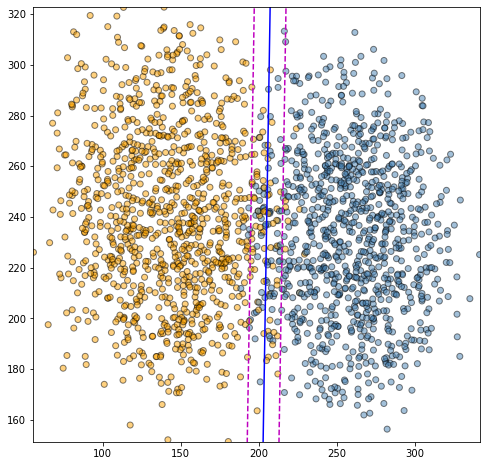

In [6]:
xx = np.linspace(x_min, x_max)
a = -w[0]/w[1]
yy = a*xx - (b)/w[1]
margin = 1 / np.sqrt(np.sum(w**2))
yy_neg = yy - np.sqrt(1 + a**2) * margin
yy_pos = yy + np.sqrt(1 + a**2) * margin
plt.figure(figsize=(8, 8))
plt.plot(xx, yy, "b-")
plt.plot(xx, yy_neg, "m--")
plt.plot(xx, yy_pos, "m--")
colors = ["steelblue", "orange"]
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [7]:
from sklearn import svm

clf = svm.SVC(kernel="linear", C=C)
clf.fit(X, y.ravel())
w = clf.coef_[0]
b = clf.intercept_
print("W:", w)
print("b:", b)


W: [-0.35930776  0.00550532]
b: [72.45455827]


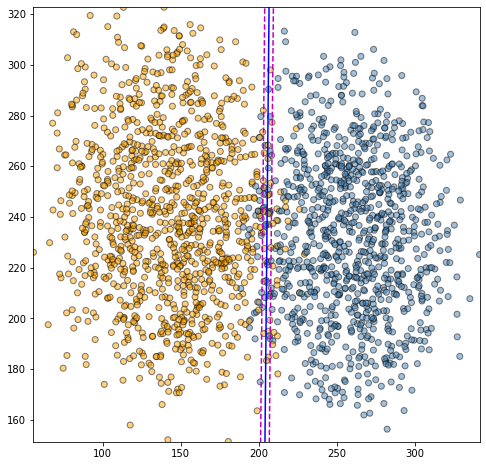

In [8]:
xx = np.linspace(x_min, x_max)
a = -w[0]/w[1]
yy = a*xx - (b)/w[1]
margin = 1 / np.sqrt(np.sum(w**2))
yy_neg = yy - np.sqrt(1 + a**2) * margin
yy_pos = yy + np.sqrt(1 + a**2) * margin
plt.figure(figsize=(8, 8))
plt.plot(xx, yy, "b-")
plt.plot(xx, yy_neg, "m--")
plt.plot(xx, yy_pos, "m--")
colors = ["steelblue", "orange"]
plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), alpha=0.5, cmap=matplotlib.colors.ListedColormap(colors), edgecolors="black")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()